In [1]:
#%% Import
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import random
import time
import datetime
import os
import sys
import pickle


from imutils import paths #
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.utils import to_categorical as to_cat
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

from tensorflow.keras import backend as K
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import backend as K

In [2]:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('drive/My Drive/FederatedLearning/FL/multiclass/kaggle/data/train.csv')

In [4]:
train.shape

(1620364, 208)

In [5]:
k = 20

In [6]:
dataTo = []
for i in range(10):
  print(i+1) 
  dff = pd.read_csv('drive/My Drive/FederatedLearning/FL/multiclass/kaggle/data/s'+str(i+1)+'.csv')
  print(dff.shape)
  # df_sample = dff.sample(frac=0.8)
  dataTo.append(dff.head(k))

result = pd.concat(dataTo)

1
(150422, 208)
2
(279404, 208)
3
(169526, 208)
4
(153663, 208)
5
(171669, 208)
6
(281117, 208)
7
(171012, 208)
8
(160816, 208)
9
(153021, 208)
10
(172732, 208)


In [7]:
result.head(10)

0         1         2         3         4         5             6  \
0  0.000039  0.000024  0.996078  0.992126  0.000376  0.000182  3.033129e-07   
1  0.000039  0.000024  0.996078  0.992126  0.000376  0.000182  1.087654e-06   
2  0.000012  0.000000  0.996078  0.000000  0.000000  0.000000  1.122244e-01   
3  0.000012  0.000000  0.996078  0.000000  0.000000  0.000000  1.020222e-02   
4  0.000012  0.000000  0.996078  0.000000  0.000000  0.000000  1.246938e-02   
5  0.000012  0.000000  0.996078  0.000000  0.000000  0.000000  1.402806e-02   
6  0.000012  0.000000  0.996078  0.000000  0.000000  0.000000  1.402806e-02   
7  0.000012  0.000000  0.996078  0.000000  0.000000  0.000000  5.611222e-02   
8  0.000012  0.000000  0.996078  0.000000  0.000000  0.000000  3.740815e-02   
9  0.000053  0.000018  0.996078  0.992126  0.000376  0.000182  4.538933e-06   

          7         8         9  ...  198  199  200  201  202  203  204  205  \
0  0.000009  0.000939  0.000726  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
1  0.000031  0.000939  0.000726  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
2  0.000000  0.000188  0.000000  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
3  0.000000  0.000188  0.000000  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
4  0.000000  0.000188  0.000000  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
5  0.000000  0.000188  0.000000  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
6  0.000000  0.000188  0.000000  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
7  0.000000  0.000188  0.000000  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
8  0.000000  0.000188  0.000000  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   
9  0.000069  0.000939  0.000545  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0   

   206  207  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0  
4  0.0  0.0  
5  0.0  0.0  
6  0.0  0.0  
7  0.0  0.0  
8  0.0  0.0  
9  0.0  0.0  

[10 rows x 208 columns]

In [8]:
result.shape, result.isnull().values.any()

((200, 208), False)

In [9]:
result.to_csv('drive/My Drive/FederatedLearning/FL/multiclass/kaggle/data/random/s0-'+str(k)+'.csv', index=False)

In [10]:
#%% experiment params
   
date = '10_26_22'

# OPTIM.
loss='categorical_crossentropy' #categorical_accuracy
metrics = ['val_accuracy']
max_round = 60 # maximum number of communication rounds

# CLIENTS
no_clients=10
no_active_clients_per_round_range = [5] # siham modified it from 5 to 10
local_batch_size =  32 # 512                  # siham modified it from 64 to 1024
local_epochs = 1                         # siham modified it from 1 to 10
learning_rate_range = [0.01] #[0.01] #[0.005] #[0.01]

# SERVER
eta = [1] # server_lr

# count number of experiments
exp_max = len(no_active_clients_per_round_range)*len(learning_rate_range)
exp_cnt = 0 # counting number of runs

In [11]:
  def LOAD_YOUR_DATA_HERE():
    X_valid = pd.read_csv('drive/My Drive/FederatedLearning/FL/multiclass/kaggle/data/X_valid.csv')
    y_valid = pd.read_csv('drive/My Drive/FederatedLearning/FL/multiclass/kaggle/data/y_valid.csv')

    return X_valid, y_valid

In [12]:
#%% LOAD DATA
X_valid, y_valid = LOAD_YOUR_DATA_HERE()

clients = {}
for i in range(no_clients):
    clients['client_'+str(i)] =  pd.read_csv('drive/My Drive/FederatedLearning/FL/multiclass/kaggle/data/s'+str(i+1)+'.csv')

num_classes = 10
shape= X_valid.shape[1:]   

## MAIN

In [13]:
#%% Few util. functions to use:

from tensorflow.keras.layers import BatchNormalization
def batch_data(data_shard, batch_size=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        data_shard: a (data, label) constituting a client's data shard
        batch_size: batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((np.asarray(list(data)), np.asarray(list(label))))

    return dataset.shuffle(len(label)).batch(batch_size)


class SimpleNN:
    @staticmethod
    def build():
      model = Sequential()
      model.add(keras.Input(shape=(198,)))

      # model.add(Dense(512))
      # model.add(Activation("relu"))

      # model.add(Dense(256))
      # model.add(Activation("relu"))

      model.add(Dense(128))
      model.add(Activation("relu"))

      model.add(Dense(64))
      model.add(Activation("relu"))
      model.add(Dropout(0.25))
    
      model.add(Dense(32))
      model.add(Activation("relu"))

      model.add(Dense(10))
      model.add(Activation("softmax"))

      # print(model.summary())
      return model

def scale_model_weights(weight, scalar):
    '''scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final

def diff_model_weights(w1, w2):
    '''difference between 2 models' weights'''
    w = []
    for i in range(len(w1)):
        w.append(w1[i]-w2[i])
    return w

def add_model_weights(w1, w2):
    if type(w2) == list:
        return [(w1[i]+w2[i]) for i in range(len(w1))]
    else:
        return [(w1[i]+w2) for i in range(len(w1))]

def combine_weights(w1, w2, beta):
    if type(beta) == float:
        beta1=(1-beta)
        return [(beta*w1[i] + beta1*w2[i]) for i in range(len(w1))]
    else:
        return [(beta[0]*w1[i] + beta[1]*w2[i]) for i in range(len(w1))]

def server_getdata():
  s0 = pd.read_csv('drive/My Drive/FederatedLearning/FL/multiclass/kaggle/data/random/s0-'+str(k)+'.csv')
  s0.sample(frac=1)
  return s0.iloc[:,0:198], s0.iloc[:,198:208]

In [14]:
x2, y2 = server_getdata()

In [15]:
x2.shape

(200, 198)

In [16]:
s = SimpleNN().build()
s.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               25472     
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 activation_1 (Activation)   (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 activation_2 (Activation)   (None, 32)                0

In [17]:

#%% process and batch data
# training data for each client
clients_batched, clients_samples = dict(), dict()
for (client_name, data_shard) in clients.items():
    countNormal = sum(data_shard.iloc[:,198]) #sum(data_shard['Attack_Normal'])
    countMalicious = data_shard.shape[0]- countNormal
    lab = [countNormal, countMalicious]
    # lab = sum(np.asarray(data_shard[i][1]) for i in range(len(data_shard)))
    yo = data_shard.iloc[:,198:208]  #[['Attack_Analysis', 'Attack_Backdoor', 'Attack_DoS', 'Attack_Exploits', 'Attack_Fuzzers', 'Attack_Generic', 'Attack_Normal', 'Attack_Reconnaissance', 'Attack_Shellcode', 'Attack_Worms']]
    xo = data_shard.iloc[:,0:198] #data_shard.drop(['Attack_Analysis', 'Attack_Backdoor', 'Attack_DoS',	'Attack_Exploits',	'Attack_Fuzzers',	'Attack_Generic',	'Attack_Normal',	'Attack_Reconnaissance', 'Attack_Shellcode', 'Attack_Worms'], axis = 1)

    # print(yo.head(1))
    clients_batched[client_name] = batch_data(zip(np.asarray(xo).astype('float32'), np.asarray(yo).astype('float32')), batch_size = local_batch_size)
    clients_samples[client_name] = sum(lab)
    
# # get names
client_names= list(clients_batched.keys())

no_samples = sum(clients_samples[cl] for cl in client_names) # get the total number of samples

# #test data for server
test_batched = tf.data.Dataset.from_tensor_slices((np.asarray(X_valid), np.asarray(y_valid))).batch(len(y_valid))

In [18]:
#train data for server
X_train_serv, y_train_serv = server_getdata()

N0 = X_train_serv.shape[0] # number of samples at server

# y_train_serv = to_cat(y_train_serv, num_classes) # one-hot encoding

# batch data for server
server_batch_size = local_batch_size #k #local_batch_size #128 #32
server_batched = tf.data.Dataset.from_tensor_slices((np.asarray(X_train_serv), 
                                                         np.asarray(y_train_serv))).batch(server_batch_size)
# specify server's number of epochs
server_epochs = []    # one epoch = entire data. 
if not server_epochs: # if not then use AUTO mode
  server_epochs = int(round(local_epochs* no_samples /no_clients /N0))

gamma = 1 # ratio bwt LRs of Server and Client


In [19]:
server_epochs

932

In [20]:
# FL method: 
for S in no_active_clients_per_round_range:
    eta_g = 1 #np.sqrt(S)
    for lr in learning_rate_range:
        sr = lr*gamma # server learning rate 
        
        exp_cnt+=1 # counting number of runs
        print('\n[RUN '+str(exp_cnt)+'/'+str(exp_max)+']')
        df_train = pd.DataFrame()
        fname = date+'_FL_NAD'+'_N0'+str(N0)+'_S'+str(S)+'_lr'+str(lr)+'_Ec'+str(local_epochs)+'_sr'+str(sr)+'_Es'+str(server_epochs)
        print(fname)
        
        #execfile('mod_learn.py')        
        K.clear_session()

        # optimizers for SERVER and CLIENTS; 
        server_optimizer = SGD(learning_rate=sr)
        client_optimizer = SGD(learning_rate=lr) 

        # create server's model
        server_model = SimpleNN().build()
        #create new local model: serv_model
        local_model = SimpleNN().build()

        #==============================================================================
        #% TRAINING SUBROUTINES:
        loss_fn = tf.keras.losses.CategoricalCrossentropy()
        val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
        # over-ride TRAIN_STEP
        @tf.function#(jit_compile=True)
        def train_step_client(x, y):
            with tf.GradientTape() as tape:
                logits = local_model(x, training=True)
                loss_value = loss_fn(y, logits)
            grads = tape.gradient(loss_value, local_model.trainable_weights)
            client_optimizer.apply_gradients(zip(grads, local_model.trainable_weights))
            #train_acc_metric.update_state(y, logits)
            return loss_value

        # over-ride TRAIN_STEP
        @tf.function#(jit_compile=True)
        def train_step_server(x, y):
            with tf.GradientTape() as tape:
                logits = server_model(x, training=True)
                loss_value = loss_fn(y, logits)
            grads = tape.gradient(loss_value, server_model.trainable_weights)
            server_optimizer.apply_gradients(zip(grads, server_model.trainable_weights))
            #train_acc_metric.update_state(y, logits)
            return loss_value

        # over-ride TEST_STEP
        @tf.function#(jit_compile=True)
        def test_step_server(x, y):
            val_logits = server_model(x, training=False)
            val_acc_metric.update_state(y, val_logits)

        #==============================================================================
        print('\n   Start training:\n')

        # initialization
        test_loss, test_acc = [], []
        train_loss, train_acc = [], []
        # get the global model's weights
        global_weights = server_model.get_weights()

        avg = []
        oneClientLoss = 0
        start_time = time.time() # start timing
        for comm_round in range(max_round):
            if comm_round ==1: client_start_time = time.time() # start timing client training

            #pick randomly S clients
            active_client_names = random.sample(client_names, S)
            
            Delta_t = [] # empty sum
            train = []
            #loop through each client
            for client in active_client_names:
                #set local model weight to the weight of the global model: x_i^t = x_t
                local_model.set_weights(global_weights)
                
                oneClientLoss = 0
                #fit local model with client's data
                for epoch in range(local_epochs):
                    for step, (x_batch_train, y_batch_train) in enumerate(clients_batched[client]):
                        loss_value = train_step_client(x_batch_train, y_batch_train)
                        # train_loss.append(loss_value)
                        oneClientLoss += loss_value
                        # print(loss_value)
                
                train.append(oneClientLoss/(step*local_epochs))  ## all clients losses throughout one round
              
                #scale the model weights
                scaling_factor = clients_samples[client]/sum(clients_samples[cl] for cl in active_client_names)
                scaled_weights = scale_model_weights(diff_model_weights(local_model.get_weights(), global_weights), 
                                                     scaling_factor)        
                #adding up SCALED_WEIGHTS
                if not Delta_t: # empty
                    Delta_t = scaled_weights
                else:
                    Delta_t = add_model_weights(Delta_t, scaled_weights)
            #EnfOfTraining
            avg.append(np.mean(train))

            if comm_round ==1: # get client training time, start measuring server time
                server_start_time = time.time()
                client_learning_time = server_start_time - client_start_time    

            # update global model
            global_weights = combine_weights(global_weights, Delta_t, [1.0, eta_g])
            server_model.set_weights(global_weights)

            for epoch in range(server_epochs):
              for step, (x_batch_train, y_batch_train) in enumerate(server_batched):
                  loss_value = train_step_server(x_batch_train, y_batch_train)

            if comm_round ==1: # get server training time, start server testing time
                server_val_time = time.time()
                server_learning_time = server_val_time - server_start_time    

            # test model
            for x, y in test_batched:
                test_step_server(x,y)
            
            val_acc = val_acc_metric.result()
            val_acc_metric.reset_states()

            test_loss.append(loss_value)   # test only. train is different for centralized 
            test_acc.append(val_acc)
            


            if comm_round ==1: # display [clients | server | evaluation] times at COMM_ROUND 2 only
                server_testing_time = time.time() - server_val_time
                per_round_time = client_learning_time + server_learning_time + server_testing_time
                print('comm_round: {:4d} | global_acc: {:6.3%} | server_loss: {:8.6f} | per round: [clients: {:3.0f}s | server: {:3.0f}s | eval: {:3.0f}s]'.format(comm_round+1, val_acc, loss_value, client_learning_time, server_learning_time, server_testing_time) )

            
            # print update
            if (comm_round+1) %10 == 0: # display training INFO
                time_elapsed = int(time.time() - start_time)
                print('comm_round: {:4d} | global_acc: {:6.3%} | server_loss: {:8.6f}'.format(comm_round+1, val_acc, loss_value), end='')
                print(' | time_elapsed: '+str(datetime.timedelta(seconds=time_elapsed))+
                      ' | finish in: '+str(datetime.timedelta(seconds=int(time_elapsed*(max_round/(comm_round+1) -1))) ) )

        # EndOfFor

        print("--- FL total time: %s seconds ---" % (time.time() - start_time))
        df_train['test_loss'] = np.asarray(test_loss)
        df_train['test_acc'] = np.asarray(test_acc)

        df_train.to_csv(fname+'.csv')
        server_model.save(fname+'_T'+str(max_round)+'.h5')

     
print('\nAll done!\n')    


[RUN 1/1]
10_26_22_FL_NAD_N0200_S5_lr0.01_Ec1_sr0.01_Es932

   Start training:

comm_round:    2 | global_acc: 39.701% | server_loss: 0.155150 | per round: [clients:  46s | server:  11s | eval:   2s]
comm_round:   10 | global_acc: 44.326% | server_loss: 0.160365 | time_elapsed: 0:09:57 | finish in: 0:49:45
comm_round:   20 | global_acc: 44.192% | server_loss: 0.269418 | time_elapsed: 0:19:57 | finish in: 0:39:54
comm_round:   30 | global_acc: 52.746% | server_loss: 0.126800 | time_elapsed: 0:29:52 | finish in: 0:29:52
comm_round:   40 | global_acc: 59.749% | server_loss: 0.175041 | time_elapsed: 0:40:02 | finish in: 0:20:01
comm_round:   50 | global_acc: 75.103% | server_loss: 0.163840 | time_elapsed: 0:50:10 | finish in: 0:10:01


comm_round:   60 | global_acc: 69.819% | server_loss: 0.211019 | time_elapsed: 1:00:13 | finish in: 0:00:00
--- FL total time: 3613.0527012348175 seconds ---

All done!



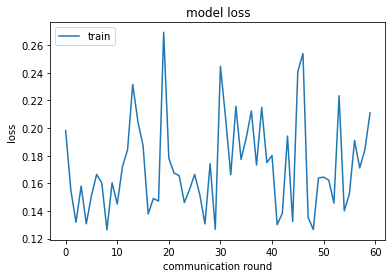

In [21]:
plt.plot(df_train['test_loss']) # server loss stored here

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('communication round')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

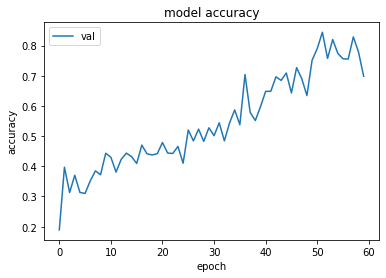

In [22]:
# plt.plot(df_train['train_acc'])
plt.plot(df_train['test_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val'], loc='upper left')
plt.show()

Test outside the loop with a different dataset

In [23]:
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics


# test model
Xx_test = pd.read_csv('drive/My Drive/FederatedLearning/FL/multiclass/kaggle/data/X_test.csv')
yy_test = pd.read_csv('drive/My Drive/FederatedLearning/FL/multiclass/kaggle/data/y_test.csv')   ## use the entire set - training

test_batched = tf.data.Dataset.from_tensor_slices((np.asarray(Xx_test), np.asarray(yy_test))).batch(len(yy_test))



In [24]:
target_names = [
    'Normal',
    'Generic',
    'Exploits',
    'Fuzzers',
    'DoS',
    'Reconnaissance',   
    'Analysis',          
    'Backdoor',
    'Shellcode',
    'Worms'
]

In [25]:
# test model
for x, y in test_batched:
    test_step_server(x,y)

val_acc = val_acc_metric.result()
val_acc_metric.reset_states()

print(val_acc)


tf.Tensor(0.6968386, shape=(), dtype=float32)


In [26]:
print("Evaluate on the excess data...")
predx=server_model.predict(Xx_test , verbose=1)

Evaluate on the excess data...
15824/15824 [==============================] - 19s 1ms/step


In [27]:
server_model.save('FL_model.h5')

In [28]:
outx = predx.argmax(axis=1)

In [29]:
outx

array([0, 0, 0, ..., 0, 0, 0])

In [30]:
predx

array([[7.75035441e-01, 1.31377063e-04, 8.59007443e-09, ...,
        4.38766905e-11, 4.42915787e-10, 3.02122993e-10],
       [9.99854565e-01, 3.75715487e-10, 2.00786748e-10, ...,
        5.72972225e-13, 3.10138547e-11, 1.70435226e-12],
       [8.89757037e-01, 3.52114846e-04, 7.02388760e-08, ...,
        3.86787324e-10, 5.78000403e-09, 3.27513705e-09],
       ...,
       [5.92967153e-01, 5.61847444e-11, 3.78300635e-09, ...,
        4.60690687e-11, 2.71297851e-09, 1.25516325e-11],
       [8.27309847e-01, 3.72938014e-10, 7.19135969e-08, ...,
        5.08563677e-11, 1.29530398e-09, 4.98506514e-11],
       [9.97746170e-01, 1.87920374e-11, 4.20887353e-11, ...,
        1.54005140e-12, 1.31861766e-09, 7.50646995e-13]], dtype=float32)

In [31]:
acc = accuracy_score(yy_test.to_numpy().argmax(axis=1), predx.argmax(axis=1))
acc

0.6968109897228081

In [32]:
cmx=confusion_matrix(yy_test.values.argmax(axis=1), predx.argmax(axis=1))
# print(cmx)

# import seaborn as sns
# plt.figure(figsize = (15, 15))
# sns.heatmap(cmx, annot = True)

In [33]:
print(cmx)

[[305105      6    613      0    144   1172 132130      0   3126     69]
 [     0  41969    359      0    107     33    305      0    181    124]
 [     0     31   3465      0    949     68   2872      0    476    880]
 [    15     73    538      0    226    859    676      0   2285    156]
 [     0     19    369      0    624     53   1972      0    116     95]
 [     0      4     33      0    122   1051    297      0    902    361]
 [     0      0     14      0     86      1    434      0      0      0]
 [     0      0     23      0     92     14    273      0     45     18]
 [     0      0      1      0      4    128      0      0    169      0]
 [     0      0      0      0      0      1      2      0      6     23]]


In [34]:
# Acurracy for each class
cmx.diagonal()/cmx.sum(axis=1)

array([0.68971325, 0.974256  , 0.39640773, 0.        , 0.19211823,
       0.37942238, 0.81121495, 0.        , 0.55960265, 0.71875   ])

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [36]:
print(classification_report(yy_test.to_numpy().argmax(axis=1),predx.argmax(axis=1)))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.69      0.82    442365
           1       1.00      0.97      0.99     43078
           2       0.64      0.40      0.49      8741
           3       0.00      0.00      0.00      4828
           4       0.27      0.19      0.22      3248
           5       0.31      0.38      0.34      2770
           6       0.00      0.81      0.01       535
           7       0.00      0.00      0.00       465
           8       0.02      0.56      0.04       302
           9       0.01      0.72      0.03        32

    accuracy                           0.70    506364
   macro avg       0.33      0.47      0.29    506364
weighted avg       0.97      0.70      0.81    506364



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
# Dummy classifiers
for i in range(10):
  a = np.sum(yy_test.iloc[:,i]==1)*100/yy_test.shape[0]   
  print(a)

87.36106832239258
8.507318845731529
1.7262285628520195
0.9534643063092952
0.6414358050730304
0.547037309129401
0.10565522035531752
0.09183117283219186
0.059640890742627836
0.0063195645820003
